# Credit Card Fraud Detection

# 1. Import Libraries

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score,
                             make_scorer, average_precision_score)

import joblib
import os

In [ ]:
import pkg_resources

# Danh sách các thư viện  import
libraries = [
    'pandas', 
    'numpy', 
    'matplotlib', 
    'seaborn', 
    'scikit-learn', 
    'imbalanced-learn', 
    'xgboost', 
    'lightgbm', 
    'joblib',
    'streamlit' 
]

# Mapping tên import sang tên package chuẩn trên PyPI (nếu khác nhau)
pkg_map = {
    'sklearn': 'scikit-learn',
    'imblearn': 'imbalanced-learn'
}

print("--- Đang kiểm tra phiên bản các thư viện ---")
with open('requirements.txt', 'w') as f:
    for lib in libraries:
        try:
            # Lấy version từ môi trường đang chạy
            version = pkg_resources.get_distribution(lib).version
            line = f"{lib}=={version}"
            print(f"✅ {line}")
            f.write(line + "\n")
        except pkg_resources.DistributionNotFound:
            # Nếu không tìm thấy version cụ thể, chỉ ghi tên thư viện
            print(f"Không lấy được version cho {lib}, chỉ ghi tên.")
            f.write(lib + "\n")

print("\nĐã tạo xong file 'requirements.txt' tại thư mục gốc!")

--- Đang kiểm tra phiên bản các thư viện ---
✅ pandas==2.3.0
✅ numpy==1.26.4
✅ matplotlib==3.9.2
✅ seaborn==0.13.2
✅ scikit-learn==1.6.1
✅ imbalanced-learn==0.12.3
✅ xgboost==3.0.5
✅ lightgbm==4.6.0
✅ joblib==1.5.1
✅ streamlit==1.37.1

🚀 Đã tạo xong file 'requirements.txt' tại thư mục gốc!


# 2. Load và Khám phá Dữ liệu

In [74]:
# Load dataset
df_train = pd.read_csv('New_Dataset/fraudTrain.csv')
df_test = pd.read_csv('New_Dataset/fraudTest.csv')

In [75]:
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [77]:
print(df_train.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [78]:
df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_train = df_train.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)

df_train.isnull().sum().sort_values(ascending=False).head()

Unnamed: 0    0
zip           0
merch_long    0
merch_lat     0
unix_time     0
dtype: int64

In [79]:
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,43.0048,-108.8964,1645,Information systems manager,1986-02-17,98e3dcf98101146a577f85a34e58feec,1325422035,43.974711,-109.741904,0
1,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,43.0048,-108.8964,1645,Information systems manager,1986-02-17,498120fc45d277f7c88e3dba79c33865,1325493897,42.018766,-109.044172,0
2,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,43.0048,-108.8964,1645,Information systems manager,1986-02-17,95f514bb993151347c7acdf8505c3d62,1325494056,42.961335,-109.157564,0
3,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,43.0048,-108.8964,1645,Information systems manager,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,42.228227,-108.747683,0
4,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,43.0048,-108.8964,1645,Information systems manager,1986-02-17,3b2ebd3af508afba959640893e1e82bc,1325509846,43.321745,-108.091143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1294934,2020-06-20 21:04:59,4992346398065154184,"fraud_Berge, Kautzer and Harris",personal_care,60.47,Benjamin,Kim,M,920 Patrick Light,...,41.1730,-89.2187,532,Audiological scientist,1956-01-09,ad7dfdf0aaa36cd7985dd1f35ca0e2fc,1371762299,40.475395,-89.076105,0
1296671,1295369,2020-06-21 00:41:01,4992346398065154184,fraud_Bernhard Inc,gas_transport,74.29,Benjamin,Kim,M,920 Patrick Light,...,41.1730,-89.2187,532,Audiological scientist,1956-01-09,6d427d735c9f9b2fd480f2c24b6525de,1371775261,40.743634,-89.553379,0
1296672,1295587,2020-06-21 02:47:59,4992346398065154184,"fraud_Reichert, Rowe and Mraz",shopping_net,246.56,Benjamin,Kim,M,920 Patrick Light,...,41.1730,-89.2187,532,Audiological scientist,1956-01-09,9814049bcc69fb31d81f4a907f2fe255,1371782879,40.215418,-88.682562,0
1296673,1296206,2020-06-21 08:04:28,4992346398065154184,fraud_Jewess LLC,shopping_pos,2.62,Benjamin,Kim,M,920 Patrick Light,...,41.1730,-89.2187,532,Audiological scientist,1956-01-09,ae39b91cd2b4897ddbbf6bf63d3e7b03,1371801868,40.762861,-88.744967,0


Fraud rate: 0.5789%


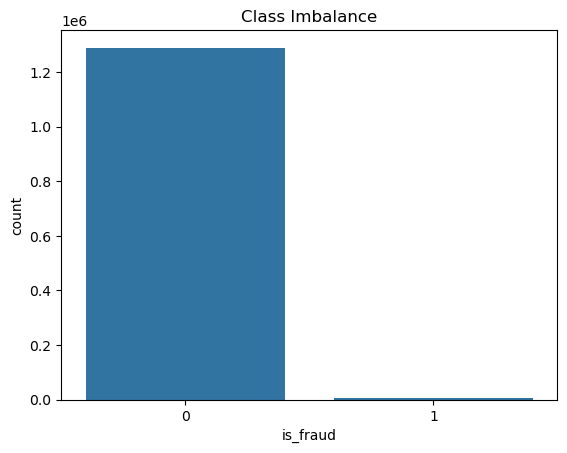

In [80]:
fraud_rate = df_train["is_fraud"].mean()
print(f"Fraud rate: {fraud_rate:.4%}")
sns.countplot(x="is_fraud", data=df_train)
plt.title("Class Imbalance")
plt.show()

In [81]:
df_train["hour"] = df_train["trans_date_trans_time"].dt.hour
df_train["dayofweek"] = df_train["trans_date_trans_time"].dt.dayofweek
df_train["is_weekend"] = (df_train["dayofweek"] >= 5).astype(int)
df_train["is_night"] = ((df_train["hour"] <= 6) | (df_train["hour"] >= 22)).astype(int)

In [82]:
df_train = df_train.sort_values(["cc_num", "trans_date_trans_time"])

In [83]:
df_train["delta_time_sec"] = (
    df_train.groupby("cc_num")["trans_date_trans_time"]
    .diff()
    .dt.total_seconds()
)

In [84]:
tmp = (
    df_train
    .set_index("trans_date_trans_time")
    .groupby("cc_num")["cc_num"]   # chọn 1 cột không null
    .rolling("1H")
    .count()
    .rename("txn_count_1h")
    .reset_index()
)

In [85]:
df_train = df_train.merge(
    tmp,
    on=["cc_num", "trans_date_trans_time"],
    how="left"
)

In [86]:
df_train["txn_count_1h"] = df_train["txn_count_1h"].fillna(1)

In [87]:
df_train["delta_time_sec"] = df_train["delta_time_sec"].fillna(999999)

In [88]:
df_train[
    ["cc_num", "trans_date_trans_time", "txn_count_1h", "is_fraud"]
].head(20)

,cc_num,trans_date_trans_time,txn_count_1h,is_fraud
0,60416207185,2019-01-01 12:47:15,1.0,0
1,60416207185,2019-01-02 08:44:57,1.0,0
2,60416207185,2019-01-02 08:47:36,2.0,0
3,60416207185,2019-01-02 12:38:14,1.0,0
4,60416207185,2019-01-02 13:10:46,2.0,0
5,60416207185,2019-01-03 13:56:35,1.0,0
6,60416207185,2019-01-03 17:05:10,1.0,0
7,60416207185,2019-01-04 13:59:55,1.0,0
8,60416207185,2019-01-04 21:17:22,1.0,0
9,60416207185,2019-01-05 00:42:24,1.0,0


In [89]:
def rolling_txn_count(df, window):
    return (
        df
        .groupby("cc_num", group_keys=False)
        .apply(
            lambda x: (
                x.set_index("trans_date_trans_time")
                 .rolling(window)
                 .count()["cc_num"]
            )
        )
    )

In [90]:
df_train["txn_count_1h"] = rolling_txn_count(df_train, "1H").values
df_train["txn_count_24h"] = rolling_txn_count(df_train, "24H").values

df_train[["txn_count_1h", "txn_count_24h"]] = (
    df_train[["txn_count_1h", "txn_count_24h"]]
    .fillna(1)
    .astype("int16")
)

In [91]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_lat,merch_long,is_fraud,hour,dayofweek,is_weekend,is_night,delta_time_sec,txn_count_1h,txn_count_24h
0,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,43.974711,-109.741904,0,12,1,0,0,999999.0,1,1
1,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,42.018766,-109.044172,0,8,2,0,0,71862.0,1,2
2,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,42.961335,-109.157564,0,8,2,0,0,159.0,2,3
3,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,42.228227,-108.747683,0,12,2,0,0,13838.0,1,4
4,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,43.321745,-108.091143,0,13,2,0,0,1952.0,2,4


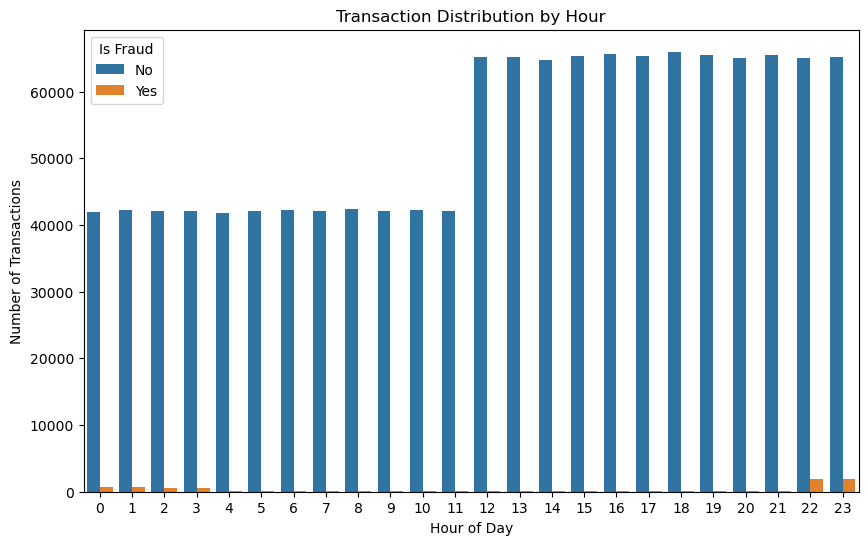

In [92]:
#vẽ phân bố giao dịch theo giờ trong ngày
plt.figure(figsize=(10, 6))
sns.countplot(x="hour", hue="is_fraud", data=df_train)
plt.title("Transaction Distribution by Hour")  
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.legend(title="Is Fraud", labels=["No", "Yes"])
plt.show()

Lượng lớn giao dịch gian lận lại xảy ra từ 22h -> 3h sáng

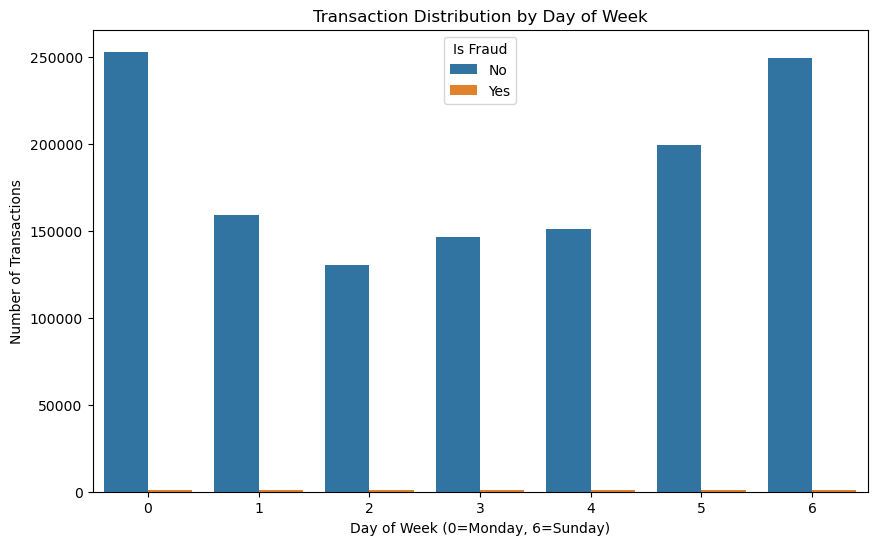

In [93]:
#Vẽ phân bố giao dịch theo ngày trong tuần
plt.figure(figsize=(10, 6))
sns.countplot(x="dayofweek", hue="is_fraud", data=df_train)
plt.title("Transaction Distribution by Day of Week")   
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Transactions")
plt.legend(title="Is Fraud", labels=["No", "Yes"])
plt.show()

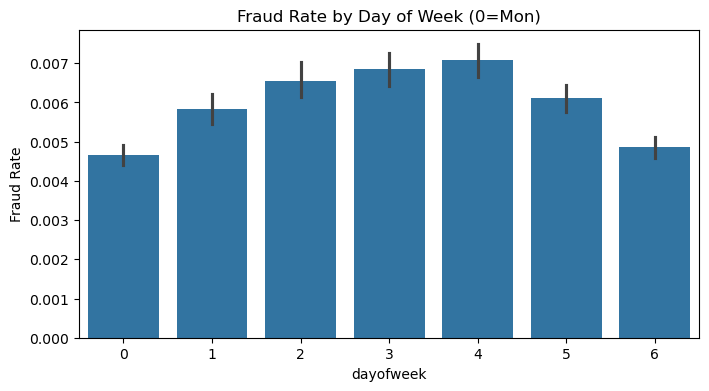

In [94]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_train,
    x="dayofweek",
    y="is_fraud",
    estimator=np.mean
)
plt.title("Fraud Rate by Day of Week (0=Mon)")
plt.ylabel("Fraud Rate")
plt.show()

In [95]:
df_train["amt_log"] = np.log1p(df_train["amt"])

In [96]:
df_train.set_index("trans_date_trans_time").groupby("cc_num").rolling("7D")["amt"].mean()

cc_num               trans_date_trans_time
60416207185          2019-01-01 12:47:15       7.270000
                     2019-01-02 08:44:57      30.105000
                     2019-01-02 08:47:36      47.430000
                     2019-01-02 12:38:14      44.270000
                     2019-01-02 13:10:46      40.852000
                                                ...    
4992346398065154184  2020-06-20 21:04:59      50.247586
                     2020-06-21 00:41:01      51.049000
                     2020-06-21 02:47:59      57.355806
                     2020-06-21 08:04:28      53.792667
                     2020-06-21 09:58:58      53.324839
Name: amt, Length: 1296715, dtype: float64

In [97]:
df_train["amt_mean_7d"] = (
    df_train
    .groupby("cc_num", group_keys=False)
    .apply(
        lambda x: (
            x.set_index("trans_date_trans_time")["amt"]
             .rolling("7D")
             .mean()
        )
    )
    .values
)

In [98]:
df_train["amt_std_7d"] = (
    df_train
    .groupby("cc_num", group_keys=False)
    .apply(
        lambda x: (
            x.set_index("trans_date_trans_time")["amt"]
             .rolling("7D")
             .std()
        )
    )
    .values
)


In [99]:
df_train[["amt_mean_7d", "amt_std_7d"]] = (
    df_train[["amt_mean_7d", "amt_std_7d"]]
    .fillna(0)
    .astype("float32")
)

In [100]:
df_train[["amt_mean_7d", "amt_std_7d"]] = (
    df_train[["amt_mean_7d", "amt_std_7d"]]
    .fillna(0)
    .astype("float32")
)

In [101]:
df_train["amt_zscore_7d"] = (
    (df_train["amt"] - df_train["amt_mean_7d"]) /
    (df_train["amt_std_7d"] + 1e-6)
)

df_train["amt_zscore_7d"] = (
    df_train["amt_zscore_7d"]
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
    .astype("float32")
)

In [102]:
df_train.drop(
    columns=["amt_mean_7d", "amt_std_7d"],
    inplace=True
)

In [103]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,is_fraud,hour,dayofweek,is_weekend,is_night,delta_time_sec,txn_count_1h,txn_count_24h,amt_log,amt_zscore_7d
0,1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,Mary,Diaz,F,9886 Anita Drive,...,0,12,1,0,0,999999.0,1,1,2.112635,0.019073
1,2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,Mary,Diaz,F,9886 Anita Drive,...,0,8,2,0,0,71862.0,1,2,3.987872,0.707107
2,2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,Mary,Diaz,F,9886 Anita Drive,...,0,8,2,0,0,159.0,2,3,4.419804,0.918900
3,2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,Mary,Diaz,F,9886 Anita Drive,...,0,12,2,0,0,13838.0,1,4,3.577669,-0.301618
4,2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,Mary,Diaz,F,9886 Anita Drive,...,0,13,2,0,0,1952.0,2,4,3.338613,-0.483583


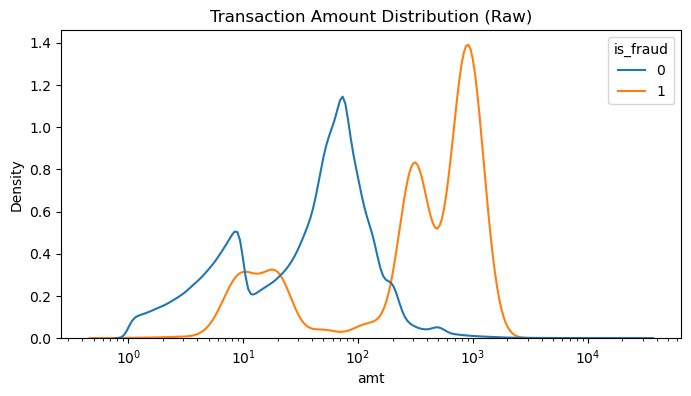

In [104]:
plt.figure(figsize=(8,4))
sns.kdeplot(
    data=df_train,
    x="amt",
    hue="is_fraud",
    log_scale=True,
    common_norm=False
)
plt.title("Transaction Amount Distribution (Raw)")
plt.show()


In [105]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(
        np.radians, [lat1, lon1, lat2, lon2]
    )
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


In [106]:
df_train["distance_km"] = haversine(
    df_train["lat"], df_train["long"], df_train["merch_lat"], df_train["merch_long"]
)

In [107]:
cat_cols = ["merchant", "category", "gender", "job", "state", "city"]

In [108]:
for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])

In [109]:
DROP_COLS = [
    "Unnamed: 0",
    "cc_num", "first", "last", "street", "zip",
    "trans_num", "unix_time",
    "lat", "long", "merch_lat", "merch_long", "dob"
]

In [110]:
df_train = df_train.drop(columns=DROP_COLS)

In [111]:
df_train.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,city_pop,job,is_fraud,hour,dayofweek,is_weekend,is_night,delta_time_sec,txn_count_1h,txn_count_24h,amt_log,amt_zscore_7d,distance_km
0,2019-01-01 12:47:15,293,8,7.27,0,272,50,1645,246,0,12,1,0,0,999999.0,1,1,2.112635,0.019073,127.606239
1,2019-01-02 08:44:57,43,2,52.94,0,272,50,1645,246,0,8,2,0,0,71862.0,1,2,3.987872,0.707107,110.308921
2,2019-01-02 08:47:36,399,2,82.08,0,272,50,1645,246,0,8,2,0,0,159.0,2,3,4.419804,0.918900,21.787261
3,2019-01-02 12:38:14,126,7,34.79,0,272,50,1645,246,0,12,2,0,0,13838.0,1,4,3.577669,-0.301618,87.204215
4,2019-01-02 13:10:46,41,6,27.18,0,272,50,1645,246,0,13,2,0,0,1952.0,2,4,3.338613,-0.483583,74.212965


### Đưa toàn bộ các cell xử lý dự liệu vào hàm để chạy cho tập test

In [112]:
def feature_engineering(df):
    df = df.copy()

    # datetime
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df = df.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)

    # time features
    df["hour"] = df["trans_date_trans_time"].dt.hour
    df["dayofweek"] = df["trans_date_trans_time"].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["is_night"] = ((df["hour"] <= 6) | (df["hour"] >= 22)).astype(int)

    # delta time
    df["delta_time_sec"] = (
        df.groupby("cc_num")["trans_date_trans_time"]
          .diff()
          .dt.total_seconds()
          .fillna(999999)
    )

    # txn count rolling
    def rolling_count(x, window):
        return (
            x.set_index("trans_date_trans_time")
             .rolling(window)["cc_num"]
             .count()
        )

    df["txn_count_1h"] = (
        df.groupby("cc_num", group_keys=False)
          .apply(lambda x: rolling_count(x, "1H"))
          .fillna(1)
          .astype("int16")
          .values
    )

    df["txn_count_24h"] = (
        df.groupby("cc_num", group_keys=False)
          .apply(lambda x: rolling_count(x, "24H"))
          .fillna(1)
          .astype("int16")
          .values
    )

    # amount
    df["amt_log"] = np.log1p(df["amt"])

    # rolling zscore 7d
    mean_7d = (
        df.groupby("cc_num", group_keys=False)
          .apply(lambda x:
              x.set_index("trans_date_trans_time")["amt"]
               .rolling("7D")
               .mean()
          ).values
    )

    std_7d = (
        df.groupby("cc_num", group_keys=False)
          .apply(lambda x:
              x.set_index("trans_date_trans_time")["amt"]
               .rolling("7D")
               .std()
          ).values
    )

    df["amt_zscore_7d"] = (
        (df["amt"] - mean_7d) / (std_7d + 1e-6)
    ).replace([np.inf, -np.inf], 0).fillna(0).astype("float32")

    # distance
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        return 2 * R * np.arcsin(np.sqrt(a))

    df["distance_km"] = haversine(
        df["lat"], df["long"], df["merch_lat"], df["merch_long"]
    )

    cat_cols = ["merchant", "category", "gender", "job", "state", "city"]
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        
    DROP_COLS = [
    "Unnamed: 0",
    "cc_num", "first", "last", "street", "zip",
    "trans_num", "unix_time",
    "lat", "long", "merch_lat", "merch_long", "dob"
    ]
    
    df = df.drop(columns=DROP_COLS)
    
    return df

In [113]:
df_test  = feature_engineering(df_test)

In [114]:
df_test.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,city_pop,job,is_fraud,hour,dayofweek,is_weekend,is_night,delta_time_sec,txn_count_1h,txn_count_24h,amt_log,amt_zscore_7d,distance_km
0,2020-06-21 13:05:42,362,6,124.66,0,258,49,1645,235,0,13,6,1,0,999999.0,1,1,4.833580,0.000000,30.457093
1,2020-06-21 16:25:36,225,9,78.52,0,258,49,1645,235,0,16,6,1,0,11994.0,1,2,4.376009,-0.707107,91.942935
2,2020-06-22 07:58:33,103,2,65.25,0,258,49,1645,235,0,7,0,0,0,55977.0,1,3,4.193435,-0.776901,121.857420
3,2020-06-22 15:32:31,373,7,87.74,0,258,49,1645,235,0,15,0,0,0,27238.0,1,3,4.485711,-0.051126,65.414164
4,2020-06-23 12:28:54,382,10,148.02,0,258,49,1645,235,0,12,1,0,0,75383.0,1,2,5.004081,1.372100,38.311273


In [115]:
set(df_train.columns) == set(df_test.columns)

True

In [116]:
df_train = df_train.sort_values("trans_date_trans_time")


In [117]:
cutoff = df_train["trans_date_trans_time"].quantile(0.8)

In [118]:
df_train.shape

(1296715, 20)

In [119]:
train_df = df_train[df_train["trans_date_trans_time"] <= cutoff].reset_index(drop=True)
valid_df = df_train[df_train["trans_date_trans_time"] > cutoff].reset_index(drop=True)

In [120]:
print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

Train shape: (1037372, 20)
Valid shape: (259343, 20)


In [121]:
print("Train fraud rate:", train_df["is_fraud"].mean())
print("Valid fraud rate:", valid_df["is_fraud"].mean())

Train fraud rate: 0.005752998924204625
Valid fraud rate: 0.005930370204709593


In [122]:
train_df

,trans_date_trans_time,merchant,category,amt,gender,city,state,city_pop,job,is_fraud,hour,dayofweek,is_weekend,is_night,delta_time_sec,txn_count_1h,txn_count_24h,amt_log,amt_zscore_7d,distance_km
0,2019-01-01 00:00:18,514,8,4.97,0,526,27,3495,370,0,0,1,0,1,999999.0,1,1,1.786747,0.209808,78.597568
1,2019-01-01 00:00:44,241,4,107.23,0,612,47,149,428,0,0,1,0,1,999999.0,1,1,4.684259,-3.356934,30.212176
2,2019-01-01 00:00:51,390,0,220.11,1,468,13,4154,307,0,0,1,0,1,999999.0,1,1,5.398660,-0.610352,108.206083
3,2019-01-01 00:01:16,360,2,45.00,1,84,26,1939,328,0,0,1,0,1,999999.0,1,1,3.828641,0.000000,95.673231
4,2019-01-01 00:03:06,297,9,41.96,1,216,45,99,116,0,0,1,0,1,999999.0,1,1,3.760269,0.915527,77.556744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037367,2020-03-06 07:14:01,497,2,48.63,1,628,3,759,212,0,7,4,0,0,114722.0,1,1,3.904595,-0.316379,63.632005
1037368,2020-03-06 07:14:37,273,2,85.91,0,32,2,2856,237,0,7,4,0,0,16214.0,1,5,4.464873,-0.198508,119.556755
1037369,2020-03-06 07:15:17,181,2,93.02,1,317,9,33804,186,0,7,4,0,0,27617.0,1,4,4.543508,-0.089738,92.804132
1037370,2020-03-06 07:16:43,442,4,45.16,1,347,15,23727,97,0,7,4,0,0,100109.0,1,1,3.832114,-0.316176,92.031087


In [123]:
train_df = train_df.drop(columns=["trans_date_trans_time"])
valid_df = valid_df.drop(columns=["trans_date_trans_time"])

In [124]:
def calc_woe_iv(
    df,
    feature,
    target="is_fraud",
    bins=10,
    eps=1e-6
):
    data = df[[feature, target]].copy()

    # Nếu feature numeric → bin
    if pd.api.types.is_numeric_dtype(data[feature]):
        data["bin"] = pd.qcut(
            data[feature].rank(method="first"),
            q=bins,
            duplicates="drop"
        )
    else:
        data["bin"] = data[feature]

    grouped = (
        data
        .groupby("bin")[target]
        .agg(["count", "sum"])
        .rename(columns={"sum": "fraud"})
    )

    grouped["non_fraud"] = grouped["count"] - grouped["fraud"]

    # Rate
    grouped["fraud_rate"] = grouped["fraud"] / (grouped["fraud"].sum() + eps)
    grouped["non_fraud_rate"] = grouped["non_fraud"] / (grouped["non_fraud"].sum() + eps)

    # WOE
    grouped["WOE"] = np.log(
        (grouped["fraud_rate"] + eps) /
        (grouped["non_fraud_rate"] + eps)
    )

    # IV
    grouped["IV"] = (grouped["fraud_rate"] - grouped["non_fraud_rate"]) * grouped["WOE"]

    iv = grouped["IV"].sum()

    return grouped.reset_index(), iv


In [125]:
def run_woe_iv(
    df,
    target="is_fraud",
    bins=10
):
    iv_list = []
    woe_tables = {}

    features = [c for c in df.columns if c != target]

    for col in features:
        try:
            table, iv = calc_woe_iv(
                df,
                feature=col,
                target=target,
                bins=bins
            )
            iv_list.append({
                "feature": col,
                "IV": iv
            })
            woe_tables[col] = table
        except Exception as e:
            print(f"Skip {col}: {e}")

    iv_df = (
        pd.DataFrame(iv_list)
        .sort_values("IV", ascending=False)
        .reset_index(drop=True)
    )

    return iv_df, woe_tables

In [126]:
iv_train_df, woe_train = run_woe_iv(train_df)
iv_valid_df, woe_valid = run_woe_iv(valid_df)

In [127]:
iv_compare = (
    iv_train_df
    .merge(
        iv_valid_df,
        on="feature",
        how="inner",
        suffixes=("_train", "_valid")
    )
)

iv_compare["IV_diff"] = (
    iv_compare["IV_train"] - iv_compare["IV_valid"]
).abs()

iv_compare.sort_values("IV_diff", ascending=False)

,feature,IV_train,IV_valid,IV_diff
0,amt,4.491150,5.814945,1.323795
1,amt_log,4.491150,5.814945,1.323795
11,dayofweek,0.021377,0.100841,0.079463
7,txn_count_1h,0.393955,0.467934,0.073979
3,is_night,1.242699,1.312152,0.069453
14,job,0.009277,0.078521,0.069243
8,txn_count_24h,0.144172,0.093033,0.051138
5,category,0.529709,0.483299,0.046410
15,state,0.006989,0.051294,0.044305
6,delta_time_sec,0.486957,0.530161,0.043204


In [128]:
TARGET = "is_fraud"

In [129]:
X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

In [130]:
X_train.dtypes

merchant            int32
category            int32
amt               float64
gender              int32
city                int32
state               int32
city_pop            int64
job                 int32
hour                int32
dayofweek           int32
is_weekend          int32
is_night            int32
delta_time_sec    float64
txn_count_1h        int16
txn_count_24h       int16
amt_log           float64
amt_zscore_7d     float32
distance_km       float64
dtype: object

In [131]:
X_valid = valid_df.drop(columns=[TARGET])
y_valid = valid_df[TARGET]

In [132]:
df_test = df_test.drop(columns=["trans_date_trans_time"])  

In [133]:
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

In [134]:
smote = SMOTE(
    sampling_strategy=0.1, 
    k_neighbors=5,
    random_state=42
)


In [135]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [136]:
X_train_sm.shape

(1134544, 18)

In [137]:
scaler = StandardScaler()


In [138]:
X_test.dtypes

merchant            int32
category            int32
amt               float64
gender              int32
city                int32
state               int32
city_pop            int64
job                 int32
hour                int32
dayofweek           int32
is_weekend          int32
is_night            int32
delta_time_sec    float64
txn_count_1h        int16
txn_count_24h       int16
amt_log           float64
amt_zscore_7d     float32
distance_km       float64
dtype: object

In [139]:
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_valid_scaled    = scaler.transform(X_valid)
X_test_scaled     = scaler.transform(X_test)

In [140]:
# ===== THỐNG KÊ CUỐI =====
total_samples = X_train_sm_scaled.shape[0] + X_valid_scaled.shape[0] + X_test_scaled.shape[0]

print(f"\n" + "="*60)
print(f"THỐNG KÊ CHIA DATA")
print(f"="*60)
print(f"   Train: {X_train_sm_scaled.shape[0]:,} ({X_train_sm_scaled.shape[0]/total_samples*100:.1f}%)")
print(f"   Valid: {X_valid_scaled.shape[0]:,} ({X_valid_scaled.shape[0]/total_samples*100:.1f}%)")
print(f"   Test:  {X_test_scaled.shape[0]:,} ({X_test_scaled.shape[0]/total_samples*100:.1f}%)")
print(f"   Total: {total_samples:,}")
print(f"\n   Features: {X_train_sm_scaled.shape[1]}")
print(f"   Train Fraud ratio: {y_train.mean():.2%}")
print(f"   Valid Fraud ratio: {y_valid.mean():.2%} (original)")
print(f"   Test Fraud ratio:  {y_test.mean():.2%} (original)")


THỐNG KÊ CHIA DATA
   Train: 1,134,544 (58.2%)
   Valid: 259,343 (13.3%)
   Test:  555,719 (28.5%)
   Total: 1,949,606

   Features: 18
   Train Fraud ratio: 0.58%
   Valid Fraud ratio: 0.59% (original)
   Test Fraud ratio:  0.39% (original)


In [ ]:
# EVALUATION FUNCTION 

def evaluate_with_custom_threshold(model, X_test, y_test, model_name, threshold=0.5):
    """Đánh giá với threshold tùy chỉnh (mặc định 0.5)"""
    print(f"\n{'='*50}")
    print(f"EVALUATING: {model_name} (threshold={threshold})")
    print(f"{'='*50}")
    
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC:  {pr:.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(['Non-Fraud', 'Fraud'])
    axes[0].set_yticklabels(['Non-Fraud', 'Fraud'])
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC={roc:.4f})')
    axes[1].plot([0, 1], [0, 1], 'navy', linestyle='--')
    axes[1].set_xlabel('FPR')
    axes[1].set_ylabel('TPR')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "Model": model_name,
        "Threshold": threshold,
        "ROC-AUC": roc,
        "PR-AUC": pr,
        "F1-Score": f1,
        "Recall": rec,
        "Precision": prec
    }

results = []

In [ ]:

# MODEL 1: LOGISTIC REGRESSION
# ===============================
print("\nTraining Logistic Regression...")

lr_model = LogisticRegression(
    C=0.1,                    # Regularization (nhỏ = stronger regularization)
    class_weight='balanced',  # Tự động cân bằng class
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

lr_model.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\n Evaluation với threshold = 0.5 (baseline):")
lr_results = evaluate_with_custom_threshold(lr_model, X_test_scaled, y_test, "Logistic Regression", 0.5)

results.append(lr_results)



Training Logistic Regression...

 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9992    0.9368    0.9670    553574
           1     0.0467    0.7986    0.0882      2145

    accuracy                         0.9362    555719
   macro avg     0.5229    0.8677    0.5276    555719
weighted avg     0.9955    0.9362    0.9636    555719

ROC-AUC: 0.9384
PR-AUC:  0.1969


In [ ]:

# MODEL 2: XGBOOST

pprint("\nTraining XGBoost...")

# scale_pos_weight cao để ép model "sợ bỏ sót fraud"
pos = y_train_sm.sum()
neg = len(y_train_sm) - pos
# Tăng weight cho fraud class để model không dám bỏ sót
spw = (neg / pos) * 2  # Nhân 2 để ép recall lên

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,      # Giảm để bắt fraud nhỏ
    gamma=0,                  # Không penalty split
    reg_lambda=0.5,
    reg_alpha=0.1,
    scale_pos_weight=spw,    # ÉP RECALL LÊN
    eval_metric="aucpr",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\n📊 Evaluation với threshold = 0.5 (baseline):")
xgb_results = evaluate_with_custom_threshold(xgb_model, X_test_scaled, y_test, "XGBoost", 0.5)

results.append(xgb_results)



Training XGBoost...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9996    0.9949    0.9972    553574
           1     0.4023    0.8890    0.5540      2145

    accuracy                         0.9945    555719
   macro avg     0.7009    0.9420    0.7756    555719
weighted avg     0.9973    0.9945    0.9955    555719

ROC-AUC: 0.9935
PR-AUC:  0.8450


In [ ]:
# MODEL 4: LIGHTGBM

print("\nTraining LightGBM...")

# Class weight cực mạnh cho fraud
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=8,
    min_child_samples=20,    # Giảm để bắt fraud nhỏ
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=0.5,
    is_unbalance=True,       # TỰ ĐỘNG CÂN BẰNG
    objective="binary",
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

lgbm_model.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\n📊 Evaluation với threshold = 0.5 (baseline):")
lgbm_results = evaluate_with_custom_threshold(lgbm_model, X_test_scaled, y_test, "LightGBM", 0.5)

results.append(lgbm_results)


Training LightGBM...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9996    0.9952    0.9974    553574
           1     0.4222    0.8974    0.5743      2145

    accuracy                         0.9949    555719
   macro avg     0.7109    0.9463    0.7859    555719
weighted avg     0.9974    0.9949    0.9958    555719

ROC-AUC: 0.9948
PR-AUC:  0.8567


In [145]:
# ===============================
# 11. VOTING ENSEMBLE (XGB + LGBM)
# ===============================
from sklearn.ensemble import VotingClassifier

print("\nTraining Voting Ensemble (XGB + LGBM)...")

voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\n📊 Evaluation với threshold = 0.5 (baseline):")
y_prob_vote = voting_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_vote = (y_prob_vote >= 0.5).astype(int)

print(classification_report(y_test, y_pred_vote, digits=4))

results.append({
    "Model": "Voting Ensemble (thresh=0.5)",
    "ROC-AUC": roc_auc_score(y_test, y_prob_vote),
    "PR-AUC": average_precision_score(y_test, y_prob_vote),
    "F1-Score": f1_score(y_test, y_pred_vote),
    "Recall": recall_score(y_test, y_pred_vote),
    "Precision": precision_score(y_test, y_pred_vote)
})


Training Voting Ensemble (XGB + LGBM)...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9996    0.9953    0.9974    553574
           1     0.4236    0.8928    0.5746      2145

    accuracy                         0.9949    555719
   macro avg     0.7116    0.9440    0.7860    555719
weighted avg     0.9974    0.9949    0.9958    555719



In [ ]:
# MODEL 2: RANDOM FOREST
# ===============================
print("\nTraining Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=10,
    min_samples_split=20,
    max_features="sqrt",
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\n📊 Evaluation với threshold = 0.5 (baseline):")
rf_results = evaluate_with_custom_threshold(rf_model, X_test_scaled, y_test, "Random Forest", 0.5)

results.append(rf_results)



Training Random Forest...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9995    0.9910    0.9952    553574
           1     0.2739    0.8774    0.4175      2145

    accuracy                         0.9906    555719
   macro avg     0.6367    0.9342    0.7064    555719
weighted avg     0.9967    0.9906    0.9930    555719

ROC-AUC: 0.9899
PR-AUC:  0.7654


### Thử qua với 5 model thì chỉ có XGBoost và LightGBM cho recall tốt và precision tương đối. Vì vậy sẽ tiến hành hyperparameter và tìm ngưỡng threshold cho Recall và Precision tốt nhất cho 2 model này

In [ ]:
''' tunning trên colab
# 12. Hyperparameter Tuning for XGBoost and LightGBM
from sklearn.model_selection import RandomizedSearchCV

# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0, 0.5, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'scale_pos_weight': [spw, spw*0.5, spw*2]
}

xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric="aucpr", tree_method="hist", n_jobs=-1, random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='average_precision',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\nTuning XGBoost hyperparameters...")
xgb_random_search.fit(X_train_sm_scaled, y_train_sm)
print("Best XGBoost params:", xgb_random_search.best_params_)
print("Best XGBoost PR-AUC:", xgb_random_search.best_score_)
'''

In [ ]:
''' tunning trên colab
# LightGBM hyperparameter grid
lgbm_param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 64, 128],
    'max_depth': [6, 8, 10],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 0.5, 1.0],
    'is_unbalance': [True]
}

lgbm_random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(objective="binary", n_jobs=-1, random_state=42, verbose=-1),
    param_distributions=lgbm_param_grid,
    n_iter=20,
    scoring='average_precision',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\nTuning LightGBM hyperparameters...")
lgbm_random_search.fit(X_train_sm_scaled, y_train_sm)
print("Best LightGBM params:", lgbm_random_search.best_params_)
print("Best LightGBM PR-AUC:", lgbm_random_search.best_score_)
'''

In [147]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.8,
    min_child_weight=1,      # Giảm để bắt fraud nhỏ
    gamma=0,                  # Không penalty split
    reg_lambda=0,
    reg_alpha=0,
    scale_pos_weight=np.float64(20.000077564475472),    # ÉP RECALL LÊN
    eval_metric="aucpr",
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train_sm_scaled, y_train_sm)
print("\nEvaluation với threshold = 0.5 (baseline):")
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

print(classification_report(y_test, y_pred_xgb, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test, y_prob_xgb):.4f}")

results.append({
    "Model": "XGBoost (thresh=0.5)",
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR-AUC": average_precision_score(y_test, y_prob_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb)
})


📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9978    0.9986    553574
           1     0.6025    0.8494    0.7050      2145

    accuracy                         0.9973    555719
   macro avg     0.8010    0.9236    0.8518    555719
weighted avg     0.9979    0.9973    0.9975    555719

ROC-AUC: 0.9937
PR-AUC:  0.8542


======= Trước khi hyperparameter =======
Training XGBoost...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9996    0.9949    0.9972    553574
           1     0.4023    0.8890    0.5540      2145

    accuracy                         0.9945    555719
   macro avg     0.7009    0.9420    0.7756    555719
weighted avg     0.9973    0.9945    0.9955    555719

ROC-AUC: 0.9935
PR-AUC:  0.8450

======= Sau khi hyperparameter =======
📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9978    0.9986    553574
           1     0.6025    0.8494    0.7050      2145

    accuracy                         0.9973    555719
   macro avg     0.8010    0.9236    0.8518    555719
weighted avg     0.9979    0.9973    0.9975    555719

ROC-AUC: 0.9937
PR-AUC:  0.8542

Giảm 0.04 recall tăng 0.2 precision 
===

In [148]:

print("\nTraining LightGBM...")

# Class weight cực mạnh cho fraud
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=128,
    max_depth=8,
    min_child_samples=20,    # Giảm để bắt fraud nhỏ
    subsample=0.6,
    colsample_bytree=1,
    reg_lambda=0.5,
    is_unbalance=True,       # TỰ ĐỘNG CÂN BẰNG
    objective="binary",
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

lgbm_model.fit(X_train_sm_scaled, y_train_sm)

# Threshold mặc định 0.5 (baseline)
print("\nEvaluation với threshold = 0.5 (baseline):")
y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lgbm = (y_prob_lgbm >= 0.5).astype(int)

print(classification_report(y_test, y_pred_lgbm, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test, y_prob_lgbm):.4f}")

results.append({
    "Model": "LightGBM (thresh=0.5)",
    "ROC-AUC": roc_auc_score(y_test, y_prob_lgbm),
    "PR-AUC": average_precision_score(y_test, y_prob_lgbm),
    "F1-Score": f1_score(y_test, y_pred_lgbm),
    "Recall": recall_score(y_test, y_pred_lgbm),
    "Precision": precision_score(y_test, y_pred_lgbm)
})


Training LightGBM...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9976    0.9985    553574
           1     0.5766    0.8490    0.6868      2145

    accuracy                         0.9970    555719
   macro avg     0.7880    0.9233    0.8426    555719
weighted avg     0.9978    0.9970    0.9973    555719

ROC-AUC: 0.9933
PR-AUC:  0.8505


======= Trước khi hyperparameter =======

Training LightGBM...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9996    0.9952    0.9974    553574
           1     0.4222    0.8974    0.5743      2145

    accuracy                         0.9949    555719
   macro avg     0.7109    0.9463    0.7859    555719
weighted avg     0.9974    0.9949    0.9958    555719

ROC-AUC: 0.9948
PR-AUC:  0.8567

======= Sau khi hyperparameter =======

Training LightGBM...

📊 Evaluation với threshold = 0.5 (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9976    0.9985    553574
           1     0.5766    0.8490    0.6868      2145

    accuracy                         0.9970    555719
   macro avg     0.7880    0.9233    0.8426    555719
weighted avg     0.9978    0.9970    0.9973    555719

ROC-AUC: 0.9933
PR-AUC:  0.8505

Giảm 0.05 recall Tăng 0.15 Precision
===

### Giải pháp cuối: Tìm Threshold lấy F1 score với recall và precision tốt nhất

In [ ]:
# ===============================
# 12. TÌM THRESHOLD TỐI ƯU (CÂN BẰNG RECALL & PRECISION)
# ===============================

from sklearn.metrics import fbeta_score

def find_optimal_threshold(model, X_val, y_val, model_name):
    """
    Tìm các threshold tối ưu theo nhiều tiêu chí (VECTORIZED - NHANH)
    """
    print(f"\n{'='*60}")
    print(f"THRESHOLD OPTIMIZATION: {model_name}")
    print(f"{'='*60}")
    
    y_prob = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    
    
    # Tránh chia cho 0
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1])
        f1_scores = np.nan_to_num(f1_scores, 0)
        
        f2_scores = 5 * precisions[:-1] * recalls[:-1] / (4 * precisions[:-1] + recalls[:-1])
        f2_scores = np.nan_to_num(f2_scores, 0)
    
    results = {}

    
    # 2. MAX F2 (ưu tiên Recall)
    best_f2_idx = np.argmax(f2_scores)
    results['Max F1'] = {
        'threshold': thresholds[best_f2_idx],
        'recall': recalls[best_f2_idx],
        'precision': precisions[best_f2_idx],
        'f1': f1_scores[best_f2_idx]
    }
    
    # 3. Recall >= 0.9 với Precision cao nhất
    valid_idx_90 = np.where(recalls[:-1] >= 0.9)[0]
    if len(valid_idx_90) > 0:
        best_90_idx = valid_idx_90[np.argmax(precisions[valid_idx_90])]
        results['Recall≥0.9'] = {
            'threshold': thresholds[best_90_idx],
            'recall': recalls[best_90_idx],
            'precision': precisions[best_90_idx],
            'f1': f1_scores[best_90_idx]
        }
    else:
        results['Recall≥0.9'] = None
    
    # 4. Recall >= 0.95 với Precision cao nhất
    valid_idx_95 = np.where(recalls[:-1] >= 0.95)[0]
    if len(valid_idx_95) > 0:
        best_95_idx = valid_idx_95[np.argmax(precisions[valid_idx_95])]
        results['Recall≥0.95'] = {
            'threshold': thresholds[best_95_idx],
            'recall': recalls[best_95_idx],
            'precision': precisions[best_95_idx],
            'f1': f1_scores[best_95_idx]
        }
    else:
        results['Recall≥0.95'] = None
    
    # In kết quả
    print("\nCÁC THRESHOLD TỐI ƯU:")
    print("-" * 60)
    for name, data in results.items():
        if data:
            print(f"\n{name}:")
            print(f"   Threshold: {data['threshold']:.4f}")
            print(f"   Recall:    {data['recall']:.4f}")
            print(f"   Precision: {data['precision']:.4f}")
            print(f"   F1-Score:  {data['f1']:.4f}")
        else:
            print(f"\n{name}: Không đạt được")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Precision-Recall vs Threshold
    ax1 = axes[0]
    ax1.plot(thresholds, precisions[:-1], 'b-', label='Precision', lw=2)
    ax1.plot(thresholds, recalls[:-1], 'g-', label='Recall', lw=2)
    ax1.plot(thresholds, f1_scores, 'r--', label='F1-Score', lw=2)
    
    # Đánh dấu các điểm tối ưu
    colors = ['purple', 'orange', 'cyan', 'magenta']
    for i, (name, data) in enumerate(results.items()):
        if data:
            ax1.axvline(x=data['threshold'], color=colors[i], linestyle=':', alpha=0.7, 
                       label=f"{name} (t={data['threshold']:.3f})")
    
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title(f'{model_name} - Threshold Analysis')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    
    # Plot 2: Precision-Recall Curve
    ax2 = axes[1]
    ax2.plot(recalls, precisions, 'b-', lw=2)
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Precision=0.5')
    ax2.axvline(x=0.9, color='r', linestyle='--', alpha=0.5, label='Recall=0.9')
    ax2.axvline(x=0.95, color='orange', linestyle='--', alpha=0.5, label='Recall=0.95')
    
    # Đánh dấu điểm tối ưu
    for i, (name, data) in enumerate(results.items()):
        if data:
            ax2.scatter(data['recall'], data['precision'], s=100, c=colors[i], 
                       marker='*', zorder=5, label=f"{name}")
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc='best', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return results


🔍 PHÂN TÍCH THRESHOLD TỐI ƯU (trên Validation Set)

🎯 THRESHOLD OPTIMIZATION: XGBoost

📊 CÁC THRESHOLD TỐI ƯU:
------------------------------------------------------------

Max F1:
   Threshold: 0.5521
   Recall:    0.8654
   Precision: 0.8047
   F1-Score:  0.8340

Recall≥0.9:
   Threshold: 0.2179
   Recall:    0.9005
   Precision: 0.6733
   F1-Score:  0.7705

Recall≥0.95:
   Threshold: 0.0185
   Recall:    0.9506
   Precision: 0.3428
   F1-Score:  0.5039


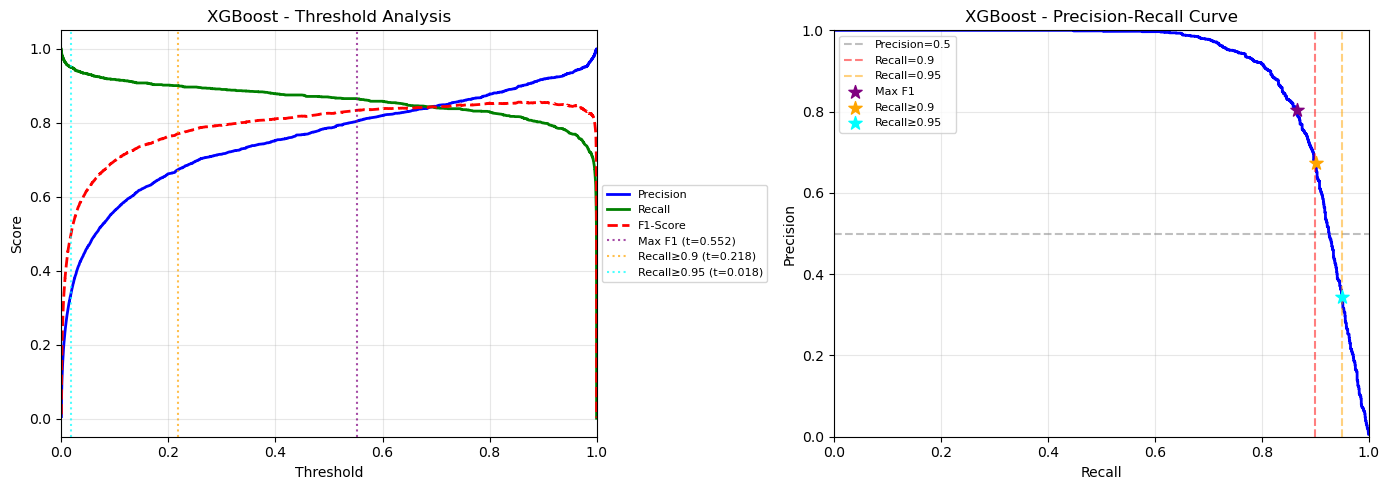


🎯 THRESHOLD OPTIMIZATION: LightGBM

📊 CÁC THRESHOLD TỐI ƯU:
------------------------------------------------------------

Max F1:
   Threshold: 0.3746
   Recall:    0.8810
   Precision: 0.7557
   F1-Score:  0.8136

Recall≥0.9:
   Threshold: 0.1699
   Recall:    0.9005
   Precision: 0.6275
   F1-Score:  0.7397

Recall≥0.95:
   Threshold: 0.0174
   Recall:    0.9506
   Precision: 0.3064
   F1-Score:  0.4634


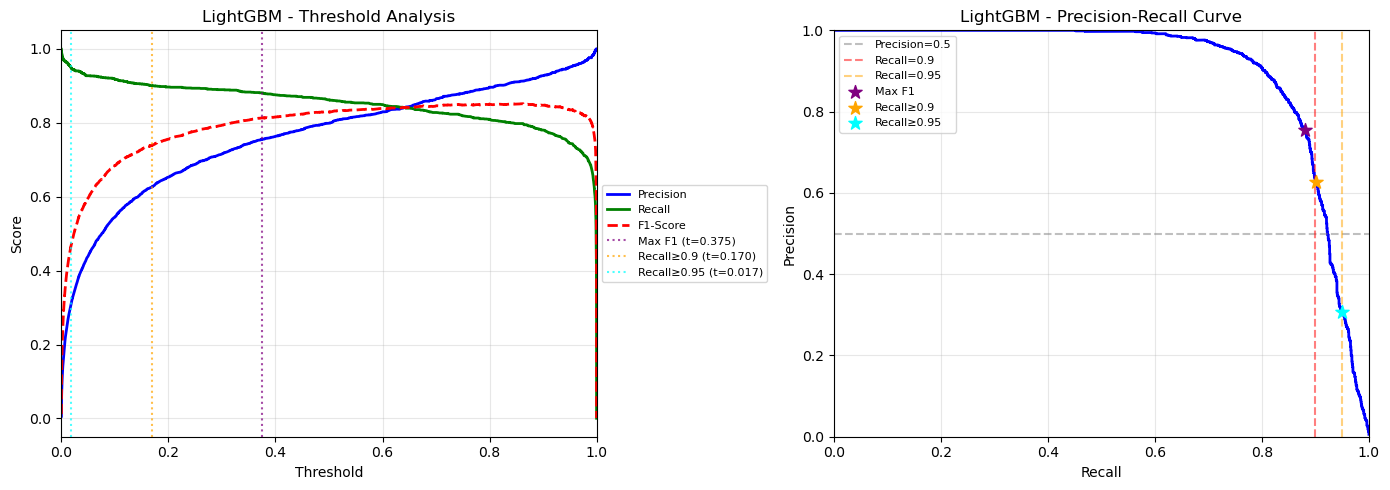

In [152]:
# ===== PHÂN TÍCH THRESHOLD CHO TỪNG MODEL =====
print("PHÂN TÍCH THRESHOLD TỐI ƯU (trên Validation Set)")
print("="*70)

threshold_analysis = {}

# XGBoost
threshold_analysis["XGB"] = find_optimal_threshold(xgb_model, X_valid_scaled, y_valid, "XGBoost")

# LightGBM
threshold_analysis["LGBM"] = find_optimal_threshold(lgbm_model, X_valid_scaled, y_valid, "LightGBM")

In [156]:
# ĐÁNH GIÁ VỚI THRESHOLD TỐI ƯU TRÊN TEST SET

print("\n" + "="*70)
print("ĐÁNH GIÁ TRÊN TEST SET VỚI CÁC THRESHOLD TỐI ƯU")
print("="*70)

# Chọn threshold strategy: "Max F2" hoặc "Recall≥0.9" hoặc "Recall≥0.95"
# F2 cân bằng tốt giữa Recall cao và Precision chấp nhận được

final_comparison = []

models = [

    (xgb_model, "XGB", "XGBoost"),
    (lgbm_model, "LGBM", "LightGBM")
]

# Thử với các strategy khác nhau
strategies = ['Max F1', 'Recall≥0.9']

for strategy in strategies:
    print(f"\n{'='*60}")
    print(f"STRATEGY: {strategy}")
    print(f"{'='*60}")
    
    for model, key, name in models:
        if threshold_analysis[key] and threshold_analysis[key].get(strategy):
            thresh = threshold_analysis[key][strategy]['threshold']
            
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = (y_prob >= thresh).astype(int)
            
            rec = recall_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            print(f"\n{name} (threshold={thresh:.4f}):")
            print(f"   Recall:    {rec:.4f}")
            print(f"   Precision: {prec:.4f}")
            print(f"   F1-Score:  {f1:.4f}")
            
            final_comparison.append({
                "Strategy": strategy,
                "Model": name,
                "Threshold": thresh,
                "Recall": rec,
                "Precision": prec,
                "F1-Score": f1
            })


ĐÁNH GIÁ TRÊN TEST SET VỚI CÁC THRESHOLD TỐI ƯU

STRATEGY: Max F1

XGBoost (threshold=0.5521):
   Recall:    0.8452
   Precision: 0.6258
   F1-Score:  0.7192

LightGBM (threshold=0.3746):
   Recall:    0.8648
   Precision: 0.5096
   F1-Score:  0.6413

STRATEGY: Recall≥0.9

XGBoost (threshold=0.2179):
   Recall:    0.8765
   Precision: 0.4484
   F1-Score:  0.5932

LightGBM (threshold=0.1699):
   Recall:    0.8942
   Precision: 0.3716
   F1-Score:  0.5250


In [158]:
# ===== BẢNG TỔNG HỢP =====
print("\n" + "="*70)
print("BẢNG TỔNG HỢP TẤT CẢ KẾT QUẢ")
print("="*70)

df_comparison = pd.DataFrame(final_comparison)
df_comparison = df_comparison.sort_values(['Strategy', 'Recall'], ascending=[True, False])
print(df_comparison.to_string(index=False))

# ===== TÌM CẤU HÌNH TỐT NHẤT =====
print("\n" + "="*70)
print("TOP 5 CẤU HÌNH TỐT NHẤT (Recall >= 0.9 VÀ Precision cao)")
print("="*70)

# Lọc các cấu hình có Recall >= 0.9
df_high_recall = df_comparison[df_comparison['Recall'] >= 0.9].copy()
if len(df_high_recall) > 0:
    # Sắp xếp theo Precision giảm dần
    df_high_recall = df_high_recall.sort_values('Precision', ascending=False)
    print(df_high_recall.head().to_string(index=False))
else:
    print(" Không có cấu hình nào đạt Recall >= 0.9")
    # Hiển thị top Recall cao nhất
    print("\nTop 5 theo Recall:")
    print(df_comparison.sort_values('Recall', ascending=False).head().to_string(index=False))


BẢNG TỔNG HỢP TẤT CẢ KẾT QUẢ
  Strategy    Model  Threshold   Recall  Precision  F1-Score
    Max F1 LightGBM   0.374622 0.864802   0.509615  0.641314
    Max F1  XGBoost   0.552088 0.845221   0.625820  0.719159
Recall≥0.9 LightGBM   0.169858 0.894172   0.371561  0.524976
Recall≥0.9  XGBoost   0.217911 0.876457   0.448366  0.593247

TOP 5 CẤU HÌNH TỐT NHẤT (Recall >= 0.9 VÀ Precision cao)
 Không có cấu hình nào đạt Recall >= 0.9

Top 5 theo Recall:
  Strategy    Model  Threshold   Recall  Precision  F1-Score
Recall≥0.9 LightGBM   0.169858 0.894172   0.371561  0.524976
Recall≥0.9  XGBoost   0.217911 0.876457   0.448366  0.593247
    Max F1 LightGBM   0.374622 0.864802   0.509615  0.641314
    Max F1  XGBoost   0.552088 0.845221   0.625820  0.719159


# Xuất ra model để deployment

In [159]:
import joblib

In [166]:
model_path = 'models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [167]:
def save_model_assets(model_obj, name, scaler_obj, threshold_val, features, mappings):
    assets = {
        'model': model_obj,
        'scaler': scaler_obj,
        'threshold': threshold_val,
        'features_order': features,
        'category_mappings': mappings
    }
    # Lưu vào đường dẫn models/tên_model.pkl
    full_path = os.path.join(model_path, f'{name}.pkl')
    joblib.dump(assets, full_path)
    print(f"✅ Đã lưu {name} tại: {full_path}")

In [161]:
features_order = X_train.columns.tolist()

In [162]:
cat_cols = ["merchant", "category", "gender", "job", "state", "city"]
category_mappings = {}

In [163]:
for col in cat_cols:
    # Lấy các giá trị duy nhất từ cột đó trong df_train
    unique_labels = df_train[col].unique().tolist()
    # Tạo mapping: nhãn -> số
    mapping = {label: i for i, label in enumerate(unique_labels)}
    category_mappings[col] = mapping

In [168]:
save_model_assets(xgb_model, 'xgb_fraud', scaler, 0.5521, features_order, category_mappings)

✅ Đã lưu xgb_fraud tại: models\xgb_fraud.pkl


In [169]:
save_model_assets(lgbm_model, 'lgbm_fraud', scaler, 0.374622, features_order, category_mappings)

✅ Đã lưu lgbm_fraud tại: models\lgbm_fraud.pkl


In [ ]:
#df_test_processed là kết quả sau khi chạy hàm feature_engineering(df_test) trong notebook
df_test_processed = feature_engineering(pd.read_csv('New_Dataset/fraudTest.csv'))

# 2. Lấy 100 dòng Fraud và 400 dòng Normal từ tập đã xử lý xong
fraud_cases = df_test_processed[df_test_processed['is_fraud'] == 1].sample(100, random_state=42)
normal_cases = df_test_processed[df_test_processed['is_fraud'] == 0].sample(400, random_state=42)

# 3. Gộp lại thành file Demo
df_demo_final = pd.concat([fraud_cases, normal_cases]).sample(frac=1, random_state=42)

# 4. Lưu lại
df_demo_final.to_csv('fraud_demo_ready.csv', index=False)